# California Housing Regression — KNN Pipeline & Hyperparameter Tuning
**Course / Program:** Data and Artificial Intelligence — Cyber Shujaa Program  
**Assignment:** End-to-end ML Workflow (Preprocessing, CV, Grid Search, Pipeline, Save Model)  
**Student Name:** Austin Njuguna  
**Student ID:** cs-da02-25037  
**Date:** <!-- add date -->


# Import

In [15]:
# 📦 Import libraries
import os

import pandas as pd
import numpy as np
import pickle

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_squared_error

import warnings
warnings.filterwarnings('ignore')

# optional: for EDA plots
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")


# Load Dataset 

In [5]:
# 1. Load dataset
X, y = fetch_california_housing(return_X_y=True, as_frame=True)

# Quick peek
print("X shape:", X.shape)
print("y shape:", y.shape)
display(X.head())
display(y.describe())


X shape: (20640, 8)
y shape: (20640,)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


count    20640.000000
mean         2.068558
std          1.153956
min          0.149990
25%          1.196000
50%          1.797000
75%          2.647250
max          5.000010
Name: MedHouseVal, dtype: float64

# Basic EDA (distributions + correlation)

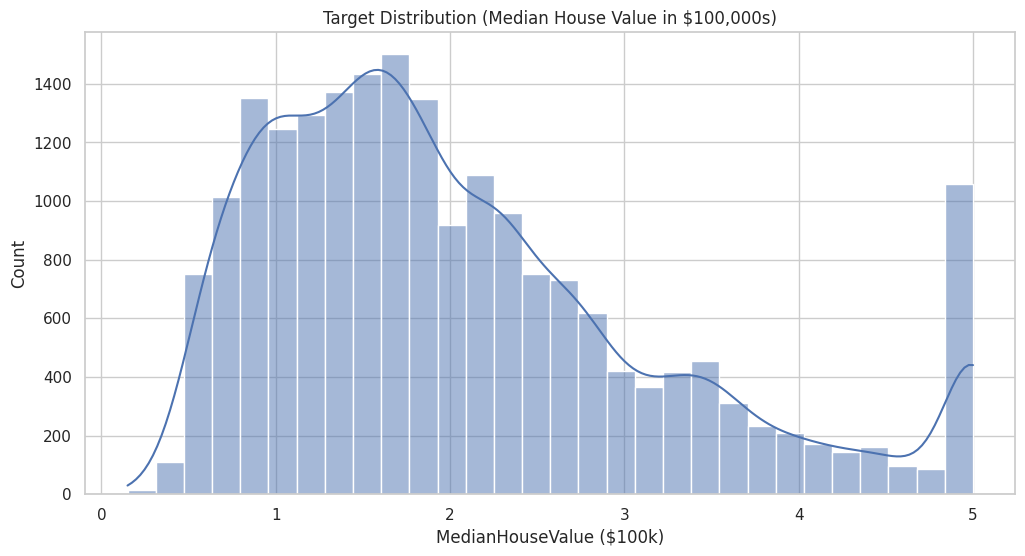

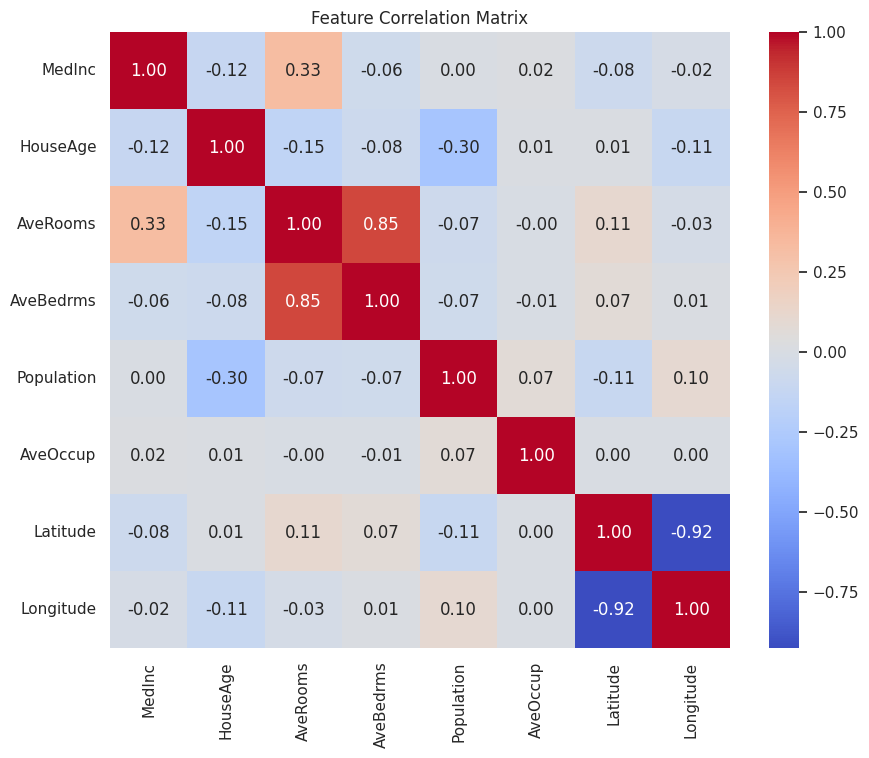

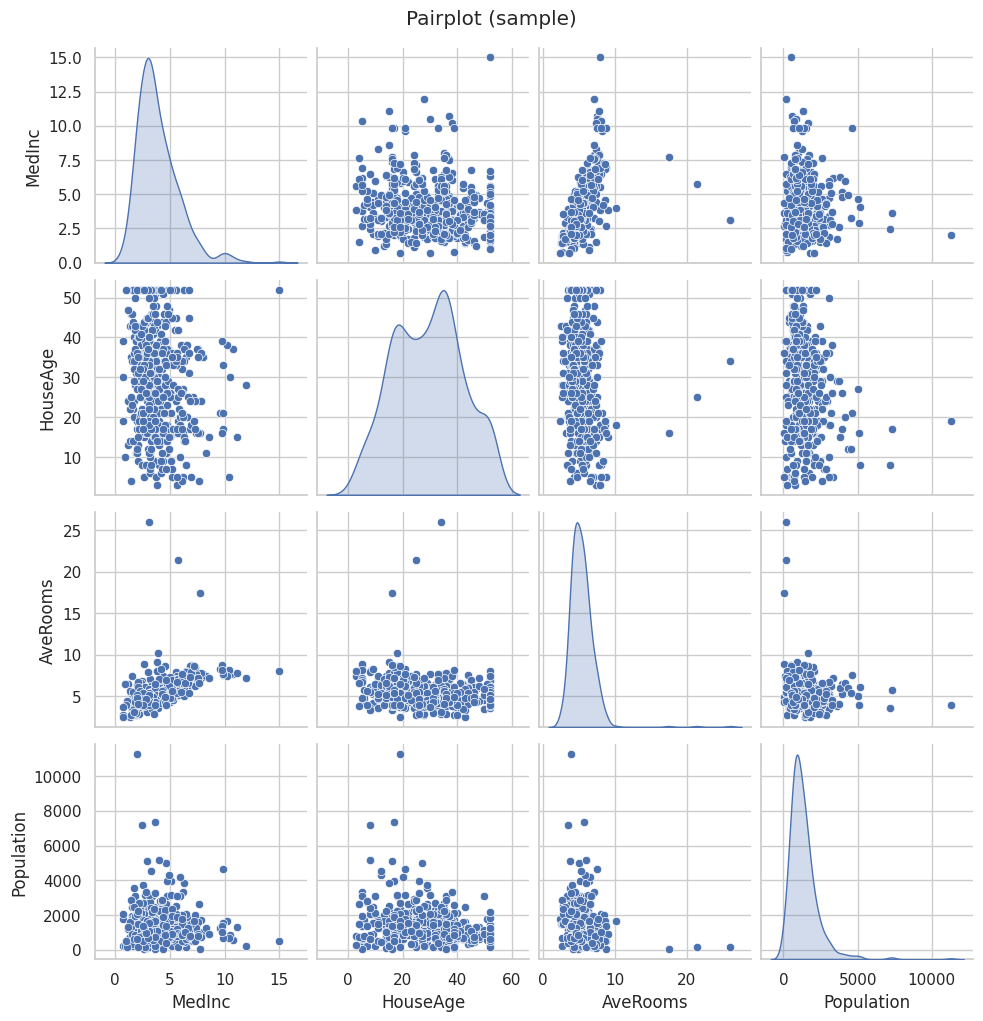

In [6]:
# Simple EDA: distributions and correlation
plt.figure(figsize=(12, 6))
sns.histplot(y, bins=30, kde=True)
plt.title("Target Distribution (Median House Value in $100,000s)")
plt.xlabel("MedianHouseValue ($100k)")
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(X.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()

# Pairplot for a few features (optional, can be heavy)
sns.pairplot(X[['MedInc','HouseAge','AveRooms','Population']].sample(500), diag_kind='kde')
plt.suptitle("Pairplot (sample)", y=1.02)
plt.show()


# Train/Test Split

In [7]:
# 2. Train-test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("X_train:", X_train.shape, "X_test:", X_test.shape)


X_train: (16512, 8) X_test: (4128, 8)


# Preprocessing: ColumnTransformer (impute + scale)

In [8]:
# 3. Preprocessing: all features are numeric in this dataset
numeric_features = X.columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),   # fill missing (if any)
    ('scaler', StandardScaler())                   # standardize features
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ],
    remainder='drop'   # drop any other columns (none expected)
)


# Build pipeline with KNeighborsRegressor

In [10]:
# 5. Build pipeline: preprocessing + KNN regressor
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('knn', KNeighborsRegressor())
])


# Hyperparameter grid & GridSearchCV setup (5-fold CV)

In [11]:
# 6. Define hyperparameter grid
param_grid = {
    'knn__n_neighbors': [3, 5, 7, 9],
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1, 2]   # p=1 (Manhattan), p=2 (Euclidean)
}

# 7. GridSearchCV with 5-fold CV and R² scoring
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    verbose=1,
    n_jobs=-1
)


# Fit GridSearchCV on training set

In [12]:
# 8. Fit the model
grid_search.fit(X_train, y_train)

print("Grid search completed.")
print("Best parameters:", grid_search.best_params_)
print("Best CV R² score:", grid_search.best_score_)


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Grid search completed.
Best parameters: {'knn__n_neighbors': 9, 'knn__p': 1, 'knn__weights': 'distance'}
Best CV R² score: 0.731266870986164


# Evaluate best model on test set

Test R² Score: 0.7221
Test MSE: 0.3642
Test RMSE: 0.6034


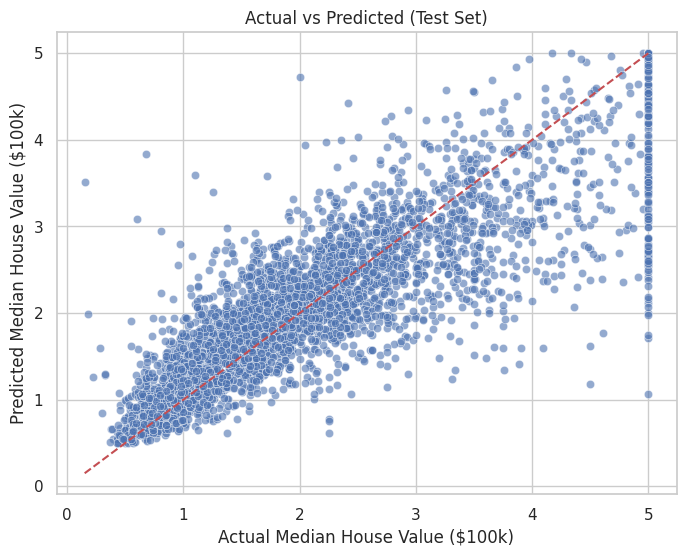

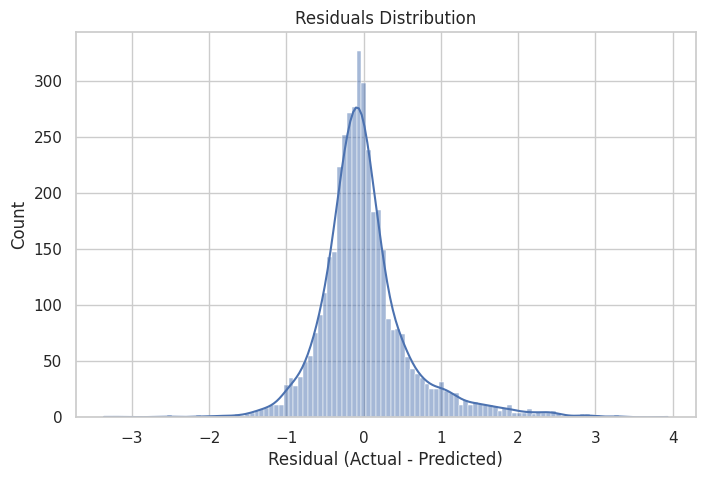

In [13]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f"Test R² Score: {r2:.4f}")
print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")

# Plot actual vs predicted
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Median House Value ($100k)")
plt.ylabel("Predicted Median House Value ($100k)")
plt.title("Actual vs Predicted (Test Set)")
plt.show()

# Residual plot
residuals = y_test - y_pred
plt.figure(figsize=(8,5))
sns.histplot(residuals, kde=True)
plt.title("Residuals Distribution")
plt.xlabel("Residual (Actual - Predicted)")
plt.show()


# Save the trained pipeline (pickle)

In [16]:

output_path = "california_knn_pipeline.pkl"
with open(output_path, 'wb') as f:
    pickle.dump(best_model, f)

print(f"📦 Final pipeline saved to '{output_path}' (size: {os.path.getsize(output_path)} bytes)")


📦 Final pipeline saved to 'california_knn_pipeline.pkl' (size: 1487492 bytes)
